In [1]:
%run data_clean.ipynb

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337351 entries, 280 to 10139999
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Rndrng_Prvdr_Mdcr_Prtcptg_Ind  337351 non-null  int64  
 1   HCPCS_Drug_Ind                 337351 non-null  int64  
 2   Tot_Benes                      337351 non-null  int64  
 3   Tot_Srvcs                      337351 non-null  float64
 4   Tot_Bene_Day_Srvcs             337351 non-null  int64  
 5   Avg_Sbmtd_Chrg                 337351 non-null  float64
 6   Avg_Mdcr_Alowd_Amt             337351 non-null  float64
 7   md                             337351 non-null  int64  
 8   gender                         337351 non-null  int64  
 9   entity                         337351 non-null  int64  
 10  facility                       337351 non-null  int64  
 11  metro                          337351 non-null  int64  
dtypes: float64(3), int64(9)
me

In [2]:
from sklearn.model_selection import train_test_split
X=df.drop(['Avg_Sbmtd_Chrg'], axis=1)
y=df['Avg_Sbmtd_Chrg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((226025, 11), (226025,), (111326, 11), (111326,))

In [4]:
# import sklearn.preprocessing
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler  #Normalizer

# normalizer = preprocessing.Normalizer()
normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)


# degree = 1 #3
# poly = PolynomialFeatures(degree)
# x_train_t = poly.fit_transform(X_train)
# x_test_t = poly.fit_transform(X_test)


In [21]:
from sklearn import linear_model # LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics # r2_score, mae, mse

# Model selection using default setting
models = dict(
    ridgeReg = linear_model.Ridge(), 
    # ridgeReg = linear_model.Ridge(alpha=0.2, max_iter=100000), 
    ols = linear_model.LinearRegression(), 
    sgdReg = linear_model.SGDRegressor(random_state=42),
    lassoReg = linear_model.Lasso(), 
    bayesianReg = linear_model.BayesianRidge(),     
    ransactReg = linear_model.RANSACRegressor(random_state=42), #robust to outliers? 0.44
    # ransactReg = linear_model.RANSACRegressor(min_samples=5000, max_trials=10000, loss='absolute_error', random_state=42), # 0.59
    #svmReg = SVR(), # running forever
    decisionTree = DecisionTreeRegressor(max_depth=3, random_state = 42),
    # randomForestReg = RandomForestRegressor(max_depth=3, random_state = 42), 
    randomForestReg = RandomForestRegressor(max_depth=11, n_estimators = 80,  random_state = 42),    
    adaBoostReg = AdaBoostRegressor(n_estimators=10, random_state=42),
    # adaBoostReg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100, random_state=42),
    knn = KNeighborsRegressor()
)


In [22]:
def train_eval_model(modeldef, modelname, X_train, X_test, y_train, y_test):
    mod = modeldef[modelname]
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)

    # model evaluation
    r2_train = mod.score(X_train, y_train)
    r2_test = mod.score(X_test, y_test)

    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    # r2 = metrics.r2_score(y_test, y_pred)  # same as r2_test  

    additn = None
    # for linear model
    if modelname in ['ols', 'ridgeReg', 'sgdReg', 'lassoReg', 'bayesianReg', 'svmReg']:
        additn = mod.coef_, mod.intercept_
    elif modelname in ['decisionTree', 'randomForestReg']:
        additn = mod.feature_importances_
    elif modelname in ['adaBoostReg']:
        additn = mod.n_features_in_

    return r2_train, r2_test, mae, mse, additn

In [23]:
scores = {}
# all models
for model in models:
    scores[model] = train_eval_model(models, model, X_train_norm, X_test_norm, y_train, y_test)

# just test one model
# scores['sgdReg']= train_eval_model(models, 'sgdReg', X_train_norm, X_test_norm, y_train, y_test)
# scores

In [24]:
df_score = pd.DataFrame(scores).T
df_score.columns=['Train R2', 'Test R2', 'MAE', 'MSE','other']
# df_score.drop(['MSE', 'other'], axis=1, inplace=True)
df_score

,Train R2,Test R2,MAE,MSE,other
ridgeReg,0.631401,0.620477,195.745099,344745.017253,"([0.8060883679234776, -20.26069704457472, -8.2..."
ols,0.631401,0.620477,195.745227,344744.879056,"([0.8060858568499647, -20.26060994083059, -8.2..."
sgdReg,0.601782,0.585766,203.197207,376275.617671,"([0.6829374444140052, -26.82726875403906, 13.7..."
lassoReg,0.631385,0.620441,195.043005,344777.67461,"([0.0, -18.965227632047295, -7.232185935011399..."
bayesianReg,0.631401,0.620476,195.744386,344745.787206,"([0.8061023514762191, -20.261182062022634, -8...."
ransactReg,0.449631,0.439014,204.020263,509579.223858,NaN
decisionTree,0.643354,0.633661,217.663284,332768.913926,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.9508578234258719, ..."
randomForestReg,0.832526,0.693402,152.1988,278502.949592,11.0
adaBoostReg,-0.127499,-0.077726,358.444562,978967.790139,11.0
knn,0.786154,0.658405,161.069475,310292.733306,NaN


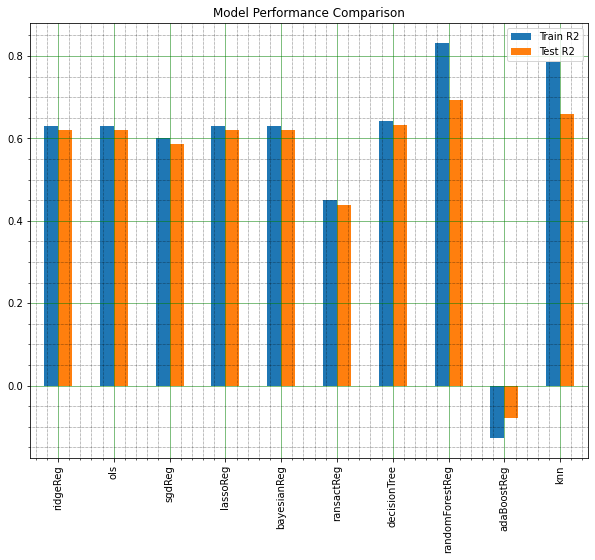

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)
df_score.plot(y=['Train R2', 'Test R2'], kind="bar", title="Model Performance Comparison")
# df_score.plot(y=['Train R2', 'Test R2'], kind="line", title="Model Performance Comparison")
# Turn on the grid
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.show()

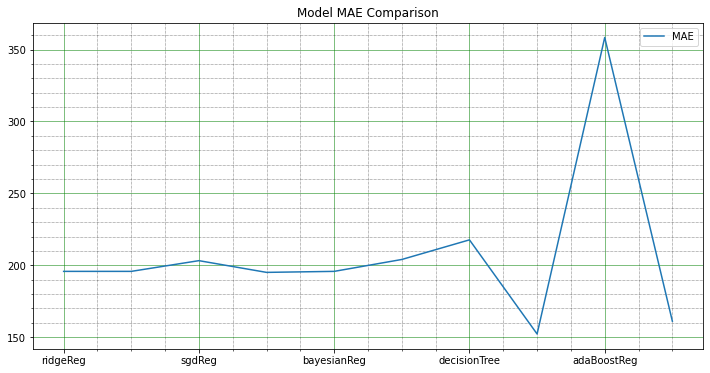

In [44]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
df_score.plot(y=['MAE'], kind="line", title="Model MAE Comparison")
# Turn on the grid
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.show()

In [ ]:
# 'ridgeReg': (0.6314012208697268,  0.6204769666486525,  195.74509910905655,  344745.0172528329,
#   (array([  0.80608837, -20.26069704,  -8.28046446,   2.16295502,
#            -6.56336537, 705.10094832, -20.55168314,   7.35865668,
#            24.64124575, 104.3299739 ,   9.90542323]),   320.34468208940035)),
#  'ols': (0.6314012208816919,  0.6204771187863705,  195.74522721375536,  344744.87905642425,
#   (array([  0.80608586, -20.26060994,  -8.28053347,   2.16300218,
#            -6.56327725, 705.10406815, -20.55195039,   7.35864484,
#            24.64108571, 104.33029678,   9.90543948]),   320.34468208940035)),
#  'sgdReg': (0.6037396878542137,  0.6020016708011291,  201.4830248978967,  361527.30877664994,
#   (array([  4.22579901, -15.948037  ,  13.25442037,   3.80025061,
#            -7.26072894, 855.67408804, -28.37741195,   6.90696038,
#            13.51861946,  97.7895985 ,  10.03267611]),   array([329.45764764]))),
#  'lassoReg': (0.6313851908912874,  0.6204410148042181,  195.04300542723905,  344777.67460993817,
#   (array([ 0.00000000e+00, -1.89652276e+01, -7.23218594e+00,  2.95267687e-01,
#           -5.55707688e+00,  7.04300563e+02, -1.90640036e+01,  5.65315084e+00,
#            2.31619230e+01,  1.03499395e+02,  8.83408819e+00]),   320.34468208940035)),
#  'bayesianReg': (0.6314012203654131,  0.6204761190227912,  195.7443858411429,  344745.78720555385,
#   (array([  0.80610235, -20.26118206,  -8.28008027,   2.16269241,
#            -6.56385597, 705.08357471, -20.55019489,   7.35872264,
#            24.64213692, 104.32817581,   9.90533277]),   320.34468208940035)),
#  'ransactReg': (0.4496305507850554,  0.43901421893650006,  204.02026308487692,  509579.2238577806,  None),
#  'decisionTree': (0.6433538657296066,  0.6336612240993403,  217.66328405567376,  332768.91392606753,
#   array([0.        , 0.        , 0.        , 0.        , 0.        ,
#          0.95085782, 0.        , 0.        , 0.04914218, 0.        ,         0.        ])),
#  'randomForestReg': (0.8325259277275661,  0.6934015607569104,  152.19880022077243,  278502.9495922564,  11),
#  'adaBoostReg': (-0.2617016052117902,  -0.22076174294630024,  365.7449070247924,  1108895.8802245157,  11),
#  'knn': (0.7861539679543617,  0.6584048108670809,  161.06947474449828,  310292.73330583953,  None)

In [ ]:
# Top 3 Models Tuning
models_selected=dict(
    # decisionTree = DecisionTreeRegressor(criterion="absolute_error", max_depth=3, max_features='sqrt', n_jobs=-1, random_state = 42),
    decisionTree = DecisionTreeRegressor(max_depth=5, random_state = 42),    
    knn=KNeighborsRegressor(n_neighbors=27, weights='distance', n_jobs=-1),
    randomForestReg = RandomForestRegressor(max_depth=11, n_estimators = 80, criterion="absolute_error", random_state = 42),
)

In [ ]:
def decision_tree_params(X_train, X_test, y_train, y_test):
    score = [0,0]
    for k in range(1,10):
        mod = DecisionTreeRegressor(max_depth=k, random_state = 42)
        mod.fit(X_train, y_train)
        kscore = mod.score(X_test, y_test)
        # print(k, type(s), s)
        if kscore > score[1]:
            score = [k, kscore, mod.score(X_train, y_train)]
    return score

decision_tree_params(X_train, X_test, y_train, y_test)

[5, 0.669603725992185, 0.7151316906844656]

[5, 0.669603725992185]

In [ ]:
def knn_params(X_train, X_test, y_train, y_test):
    score = [0,0]
    for k in range(1,38):
        mod = KNeighborsRegressor(n_neighbors=k, weights='distance', n_jobs=-1)
        mod.fit(X_train, y_train)
        kscore = mod.score(X_test, y_test)
        # print(k, type(s), s)
        if kscore > score[1]:
            score = [k, kscore, mod.score(X_train, y_train)]
    return score

knn_params(X_train, X_test, y_train, y_test)

# [27, 0.6714346637505537, 0.999743422999869]

In [77]:
def random_forest_params(X_train, X_test, y_train, y_test):
    score = [0,0,0]
    decreases = 0
    for k in range(1,20):
        mod = RandomForestRegressor(max_depth=k, random_state = 42)
        mod.fit(X_train, y_train)
        kscore = mod.score(X_test, y_test)
        if kscore > score[1]:
            score = [k, kscore, mod.score(X_train, y_train)]
        else:
            decreases += 1
        if decreases > 3:
            break
    return score

random_forest_params(X_train_norm, X_test_norm, y_train, y_test)
# max_depth, test score, train score
# [11, 0.6920899584135215, 0.8327490435554471]
# [11, 0.6919399590827846, 0.8327441028092778]


[11, 0.6919399590827846, 0.8327441028092778]

In [ ]:
def random_forest_params2(X_train, X_test, y_train, y_test):
    score = [0,0,0]
    decreases = 0
    for d in range(1,20):
        for e in range(10,500):
            mod = RandomForestRegressor(max_depth=d, n_estimators=e, random_state = 42)
            mod.fit(X_train, y_train)
            testscore = mod.score(X_test, y_test)
            if testscore > score[2]:
                score = [d, e, testscore]
                decreases = 0
            else:
                decreases += 1
            if decreases > 5:
                break
                
    # find train score for selected parameter
    mod = RandomForestRegressor(max_depth=score[0], n_estimators=score[1], random_state = 42)
    mod.fit(X_train, y_train)
    trainscore = mod.score(X_train, y_train)
    score = [trainscore, score[2], score[0], score[1]]
    
    return score

random_forest_params2(X_train_norm, X_test_norm, y_train, y_test)
# train score, test score, max_depth, n_estimators
# [0.7778913137033234, 0.6917034299280533, 8, 10]

In [ ]:
from sklearn.model_selection import GridSearchCV

def random_forest_search(X_train, X_test, y_train, y_test):
    mod = RandomForestRegressor(max_depth=11, random_state = 42, n_jobs=-1)
    param_grid = { 
        'n_estimators': [10, 20, 50, 80, 90, 100, 300],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [5,6,7,8,9,10,11,12],
#         'criterion' :['squared_error', 'absolute_error', 'poisson']
        'criterion' :['mse', 'poisson']
    }
    grid = GridSearchCV(estimator=mod, param_grid=param_grid, cv= 5)
    grid.fit(X_train, y_train)

    return grid.best_score_, grid.best_params_

random_forest_search(X_train_norm, X_test_norm, y_train, y_test)
# running for hours
# 0.6963683409469337, {'criterion': 'mse',  'max_depth': 8,  'max_features': 'auto',  'n_estimators': 300}

In [76]:
# best performance model

# mod = RandomForestRegressor(max_depth=8, n_estimators=300, max_features='auto', random_state = 42)                  # 0.6900949772571248
# mod = RandomForestRegressor(max_depth=8, n_estimators=10, max_features='auto', criterion='mse', random_state = 42)  # 0.6917034299280533
# mod = RandomForestRegressor(max_depth=8, random_state = 42)                                                         # 0.6905278257320782
# mod = RandomForestRegressor(max_depth=11, n_estimators=17, max_features='auto', criterion='mse', random_state = 42) # 0.6875431781997527
mod = RandomForestRegressor(max_depth=11, random_state = 42)                                                          # 0.6919399590827846

mod.fit(X_train_norm, y_train)

y_pred = mod.predict(X_test_norm)

# model evaluation
r2_train = mod.score(X_train_norm, y_train)
r2_test = mod.score(X_test_norm, y_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)

print('best randomForestReg:', r2_train, r2_test, mae, mse)

# 'randomForestReg': (0.8325314806060101,  0.6936608715388014,  0.6936608715388014,  152.1980130722941,  278267.40104283777,  None)

best randomForestReg: 0.7816004554733729 0.6905278257320782 157.60897608508745 281113.34670562134


In [81]:
mod.feature_importances_, mod.n_features_in_

(array([0.00000000e+00, 1.25982126e-03, 1.77550806e-02, 1.84188447e-02,
        1.69099950e-02, 8.88625108e-01, 8.44531238e-03, 7.39444106e-03,
        1.58814857e-02, 2.51266254e-02, 1.83285711e-04]),
 11)

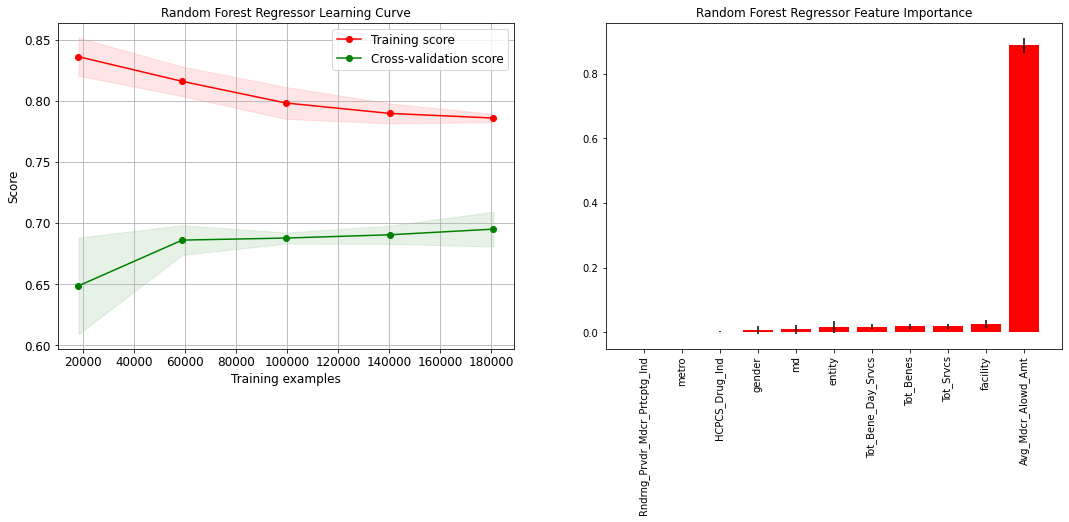

In [82]:
import scikitplot as skplt

fig = plt.figure(figsize=(18,6))

ax1 = fig.add_subplot(121)
skplt.estimators.plot_learning_curve(mod, X_train_norm, y_train,
                                     cv=5, shuffle=True, scoring="r2",
                                     n_jobs=-1, title_fontsize="large", text_fontsize="large",
                                     title="Random Forest Regressor Learning Curve", ax=ax1)

ax2 = fig.add_subplot(122)
skplt.estimators.plot_feature_importances(mod, feature_names=X.columns,
                                         title="Random Forest Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending", ax=ax2);


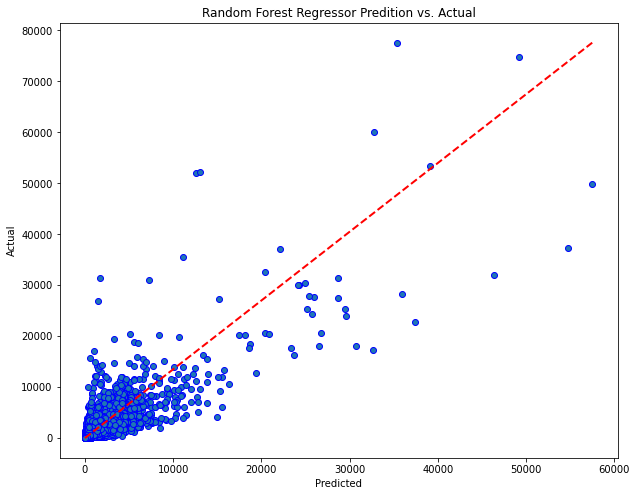

In [70]:
df_preds = pd.DataFrame({"preds":y_pred, "actual":y_test})
df_preds["residuals"] = df_preds["actual"] - df_preds["preds"]

# fig, ax = plt.subplots()
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(df_preds.preds, df_preds.actual, edgecolors=(0, 0, 1))
ax.plot([df_preds.preds.min(), df_preds.preds.max()], [df_preds.actual.min(), df_preds.actual.max()], 'r--', lw=2)
# ax.plot(df_preds.preds, df_preds.preds, 'r--', lw=2)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Random Forest Regressor Actual and Predition Data View')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2a38315d-fdd6-44a6-afc3-6dd2e5aaa65e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>